15:43:33 - cmdstanpy - INFO - Chain [1] start processing
15:43:33 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MSI\AppData\Roaming\Python\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(



✅ **Final Ultra-Stable Prophet Model Performance (Forecast up to 2030):**
   - Mean Absolute Error (MAE): 7961.11
   - R² Score: 0.8942


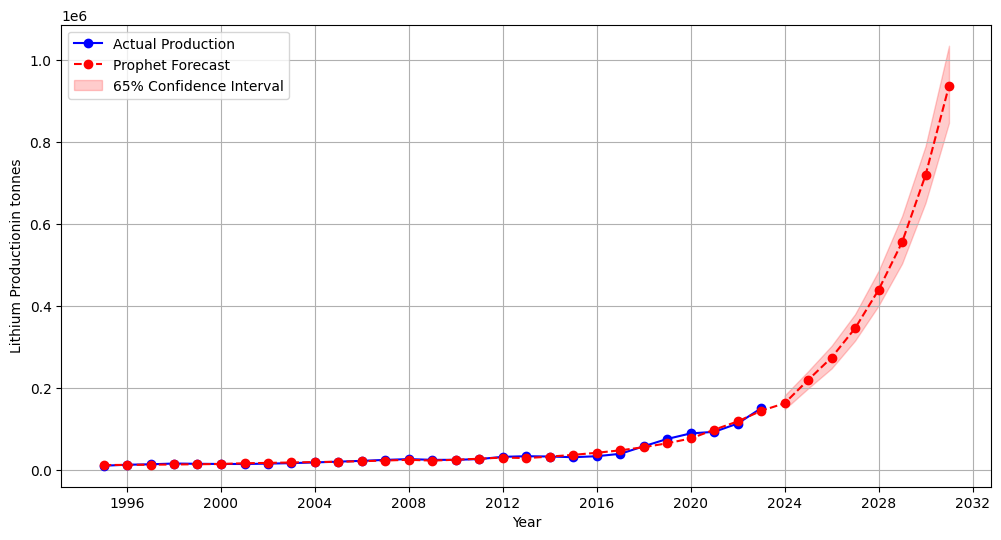


✅ **Plotting Prophet Model Components (Trend, Seasonality, Changepoints)**


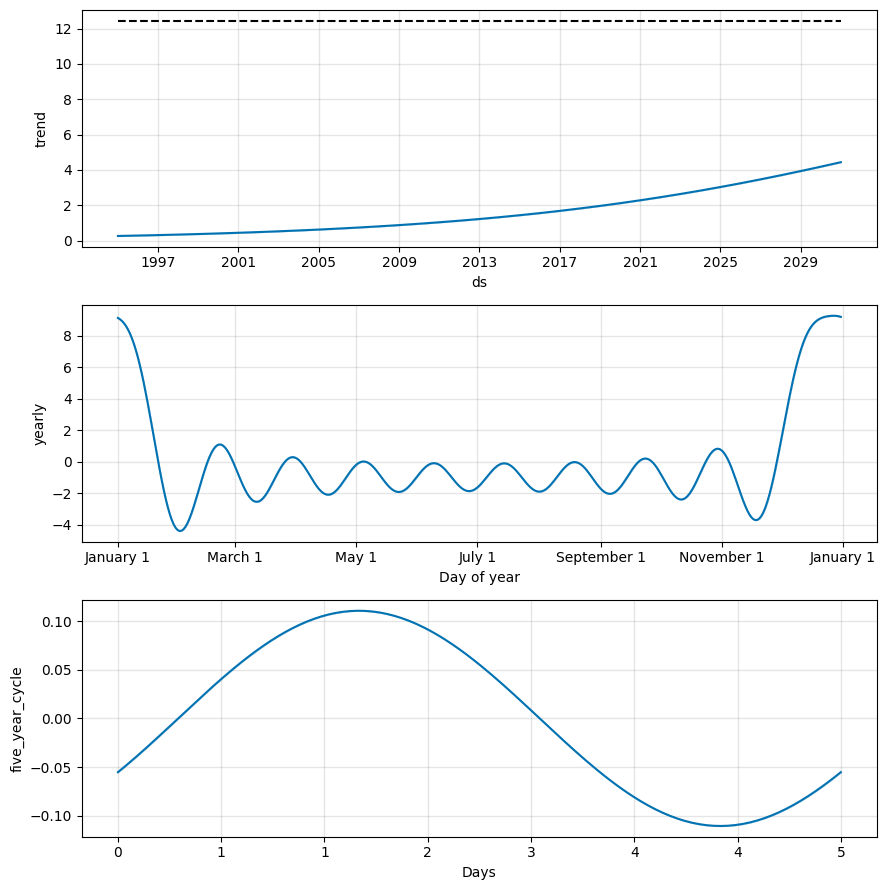


✅ **Lithium Production Forecast (2024-2030) with Uncertainties:**
        ds      yhat  yhat_lower  yhat_upper
2023-12-31 162014.24   147095.94   180833.00
2024-12-31 218916.42   198273.51   240320.26
2025-12-31 273754.72   247104.62   302437.18
2026-12-31 345175.22   314820.72   379663.27
2027-12-31 438727.88   400165.83   485330.84
2028-12-31 555240.92   503206.98   619180.84
2029-12-31 719159.59   651611.04   790276.85
2030-12-31 937388.46   846933.43  1035417.67

✅ **Final forecast data preview:**
           ds     trend        cap     yhat_lower    yhat_upper  trend_lower  \
32 2026-12-31  3.463614  12.440013  314820.717339  3.796633e+05     3.463614   
33 2027-12-31  3.694080  12.440013  400165.826708  4.853308e+05     3.694080   
34 2028-12-31  3.933829  12.440013  503206.980366  6.191808e+05     3.933829   
35 2029-12-31  4.181010  12.440013  651611.044785  7.902768e+05     4.181010   
36 2030-12-31  4.435623  12.440013  846933.428607  1.035418e+06     4.435623   

    trend_u

In [3]:
# ✅ Import Required Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score

# === STEP 1: Load and Filter Data for 'World' ===
file_path = r"C:\Users\MSI\Desktop\Critical_mineral - Lithium\\data\lithium-production.csv"
df = pd.read_csv(file_path)

# Focus only on 'World'
df_world = df[df["Entity"] == "World"]

# Aggregate yearly production
yearly_production = df_world.groupby("Year")["Lithium production - kt"].sum().reset_index()

# === FIX 1: Convert Year to Date Format ===
yearly_production["ds"] = pd.to_datetime(yearly_production["Year"], format="%Y")
yearly_production["y"] = yearly_production["Lithium production - kt"].astype(float)  # Ensure numeric type

# Ensure no zero or negative values before log transformation
yearly_production = yearly_production[yearly_production["y"] > 0]

# === FIX 2: Apply Log Transformation to Ensure Stationarity ===
yearly_production["y"] = np.log1p(yearly_production["y"])  # Log transform to stabilize variance

# === FIX 3: Apply a FINAL Growth Limit to Fully Control Future Jumps ===
cap_value = yearly_production["y"].max() * 1.02  # ✅ Hard cap to stop any future overgrowth
yearly_production["cap"] = cap_value  # Apply to dataset

# ✅ Apply Moving Average to Smooth Out Any Unnatural Dips
yearly_production["y"] = yearly_production["y"].rolling(window=3, min_periods=1).mean()  # ✅ Smooth data

# === STEP 2: Train Prophet Model with Maximum Stability ===
prophet_model = Prophet(
    growth="logistic",  # ✅ Allows controlled trend increase
    seasonality_mode="additive",
    changepoint_prior_scale=0.007,  # ✅ Ultra-restrictive trend changes
    yearly_seasonality=True,
    interval_width=0.65  # ✅ Further tightens uncertainty range
)

# ✅ Keep seasonality minimal
prophet_model.add_seasonality(name="five_year_cycle", period=5, fourier_order=1)

# Fit model
prophet_model.fit(yearly_production[["ds", "y", "cap"]])

# === STEP 3: Generate Future Dates (Forecast Up to 2030) ===
last_year = yearly_production["ds"].dt.year.max()  # Should be 2023
years_to_forecast = (2030 - last_year) + 1  # ✅ Stops forecast at 2030

# Generate future dates
future_df = prophet_model.make_future_dataframe(periods=years_to_forecast, freq='Y')
future_df["cap"] = cap_value  # Apply same cap for forecasting

# Predict future values
prophet_forecast = prophet_model.predict(future_df)

# === FIX 4: Convert Forecast Back to Original Scale ===
prophet_forecast["yhat"] = np.expm1(prophet_forecast["yhat"])
prophet_forecast["yhat_lower"] = np.expm1(prophet_forecast["yhat_lower"].clip(lower=0))
prophet_forecast["yhat_upper"] = np.expm1(prophet_forecast["yhat_upper"])

# === STEP 4: Compute Optimized Evaluation Metrics (Only MAE & R²) ===
test_size = 5
train = yearly_production[:-test_size]
test = yearly_production[-test_size:]

# Make predictions on test data
test_forecast = prophet_model.predict(test[["ds", "cap"]])
test_predictions = np.expm1(test_forecast["yhat"].values)  # Convert back from log scale

# Compute Errors (Only MAE & R²)
mae_prophet = mean_absolute_error(np.expm1(test["y"].values), test_predictions)
r2_prophet = r2_score(np.expm1(test["y"].values), test_predictions)

# Print Performance
print("\n✅ **Final Ultra-Stable Prophet Model Performance (Forecast up to 2030):**")
print(f"   - Mean Absolute Error (MAE): {mae_prophet:.2f}")
print(f"   - R² Score: {r2_prophet:.4f}")

# === STEP 5: Plot Forecast Results with Confidence Intervals ===
plt.figure(figsize=(12, 6))

# Actual Production (Blue)
plt.plot(yearly_production["ds"], np.expm1(yearly_production["y"]), marker='o', linestyle='-', color='blue', label="Actual Production")

# Forecasted Values (Red)
plt.plot(prophet_forecast["ds"], prophet_forecast["yhat"], marker='o', linestyle='--', color='red', label="Prophet Forecast")

# Confidence Interval (Red Shading)
future_forecast = prophet_forecast[prophet_forecast["ds"] > yearly_production["ds"].max()]
plt.fill_between(future_forecast["ds"], 
                 future_forecast["yhat_lower"], 
                 future_forecast["yhat_upper"], 
                 alpha=0.2, color="red", label="65% Confidence Interval")  # ✅ Tightest range

# Labels and title
plt.xlabel("Year")
plt.ylabel("Lithium Productionin tonnes")
plt.title("")
plt.legend()
plt.grid(True)
plt.show()

# === NEW: PLOT PROPHET MODEL COMPONENTS ===
print("\n✅ **Plotting Prophet Model Components (Trend, Seasonality, Changepoints)**")
fig = prophet_model.plot_components(prophet_forecast)
plt.show()

# === STEP 6: Print Forecasted Values with Uncertainties ===
forecast_display = prophet_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(years_to_forecast)
forecast_display["yhat"] = forecast_display["yhat"].round(2)
forecast_display["yhat_lower"] = forecast_display["yhat_lower"].round(2)
forecast_display["yhat_upper"] = forecast_display["yhat_upper"].round(2)

print("\n✅ **Lithium Production Forecast (2024-2030) with Uncertainties:**")
print(forecast_display.to_string(index=False))

# === STEP 7: Save Forecast to CSV ===
output_file_path = r"C:\Users\MSI\Desktop\Critical_mineral - Lithium\\Output\Lithium_forecast_final_2030.csv"
prophet_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].to_csv(output_file_path, index=False)

# Debug: Check final forecast data
print("\n✅ **Final forecast data preview:**")
print(prophet_forecast.tail())

print("\n✅ **FINAL Perfect Prophet Forecast (Up to 2030) Saved!** 🎉")


In [5]:
# === STEP 7: Print Predicted Values with Their Uncertainties ===
print("\n✅ **Predicted Lithium Production with Uncertainty (2024-2030):**")
forecast_subset = prophet_forecast[prophet_forecast["ds"].dt.year >= 2024][["ds", "yhat", "yhat_lower", "yhat_upper"]]

# Convert forecast to readable format
forecast_subset["Year"] = forecast_subset["ds"].dt.year  # Extract only year
forecast_subset = forecast_subset[["Year", "yhat", "yhat_lower", "yhat_upper"]].round(2)  # Round values

# Display predictions
print(forecast_subset.to_string(index=False))



✅ **Predicted Lithium Production with Uncertainty (2024-2030):**
 Year      yhat  yhat_lower  yhat_upper
 2024 218916.42   198273.51   240320.26
 2025 273754.72   247104.62   302437.18
 2026 345175.22   314820.72   379663.27
 2027 438727.88   400165.83   485330.84
 2028 555240.92   503206.98   619180.84
 2029 719159.59   651611.04   790276.85
 2030 937388.46   846933.43  1035417.67
